In [1]:
import os

os.chdir("../..")
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

In [4]:
from shelved.full_gtex_dataset.dataset.unified_alternative_dataset import UnifiedAlternativeDataset
from modular_splicing.models.modules.lssi_in_model import BothLSSIModels

from modular_splicing.utils.run_batched import run_batched

In [5]:
amount = 20_000
cl = 50

In [6]:
uad = UnifiedAlternativeDataset(
    path="../data/canonical_and_gtex_dataset/dataset_test_0.h5",
    post_processor_spec=dict(type="IdentityPostProcessor"),
    underlying_ordering=["spliceai_canonical", "spliceai_gtex"],
    sl=5000,
    cl=cl,
    cl_max=10_000,
    iterator_spec=dict(type="FullyRandomIter", shuffler_spec=dict(type="SeededShuffler", seed=0)),
)

In [7]:
data = [x for x in tqdm.tqdm(itertools.islice(uad, amount), total=amount)]
xs = np.array([item["inputs"]["x"] for item in data])
ys = np.array([item["outputs"]["y"] for item in data])

In [8]:
sp = {
    "Cano": BothLSSIModels(
        acceptor="model/splicepoint-model-acceptor-1",
        donor="model/splicepoint-donor2-2.sh",
    )
    .cuda()
    .eval(),
    "GTEx": BothLSSIModels(
        acceptor="model/msp-216d1_1",
        donor="model/msp-216c1_1",
    )
    .cuda()
    .eval(),
}

In [9]:
yps = {}
for k in sp:
    yps[k] = run_batched(lambda x: sp[k].forward_just_splicepoints(x), xs, 512, pbar=tqdm.tqdm)
    yps[k] = yps[k][:,cl//2:-cl//2]

In [10]:
cano = ys[:,:,1:3]
gtex = ys[:,:,4:6]

In [11]:
def cumulative_below(buckets, scores):
    scores = np.random.RandomState(0).choice(scores, size=min(20_000, len(scores)), replace=False)
    return 100 * (scores <= buckets[:, None]).mean(1)



def plot_all(ax, k, c):
    def masked(mask):
        return yps[k][:,:,c][mask[:,:,c]]
    
    bar = np.quantile(masked(cano == 0), [0.980247, 0.9850688][c])
    buckets = -np.arange(0, -bar * 3, 0.01)
    def plot_cumulative_below(mask, color, name):
        ax.plot(
            buckets,
            cumulative_below(buckets, masked(mask)),
            label=f"{name} [b.= {(masked(mask) <= bar).mean():.2%}]",
            color=color,
        )
    ax.axvline(bar, label=f"std. thresh. = {bar:.2f}", color="black")
    plot_cumulative_below(cano == 1, "blue", "Cano")
    plot_cumulative_below((gtex == 1) & (cano == 0), "red", "GTEx - Cano")
    plot_cumulative_below(gtex == 1, "purple", "GTEx")
    plot_cumulative_below(cano == 0, "orange", "~Cano")
    plot_cumulative_below(gtex == 0, "green", "~GTEx")
    ax.set_xlabel("Score threshold")
    ax.set_ylabel("Points with score below threshold [%]")
    ax.set_title(f"Trained on {k}/{['Acc', 'Don'][c]}")
    ax.legend()


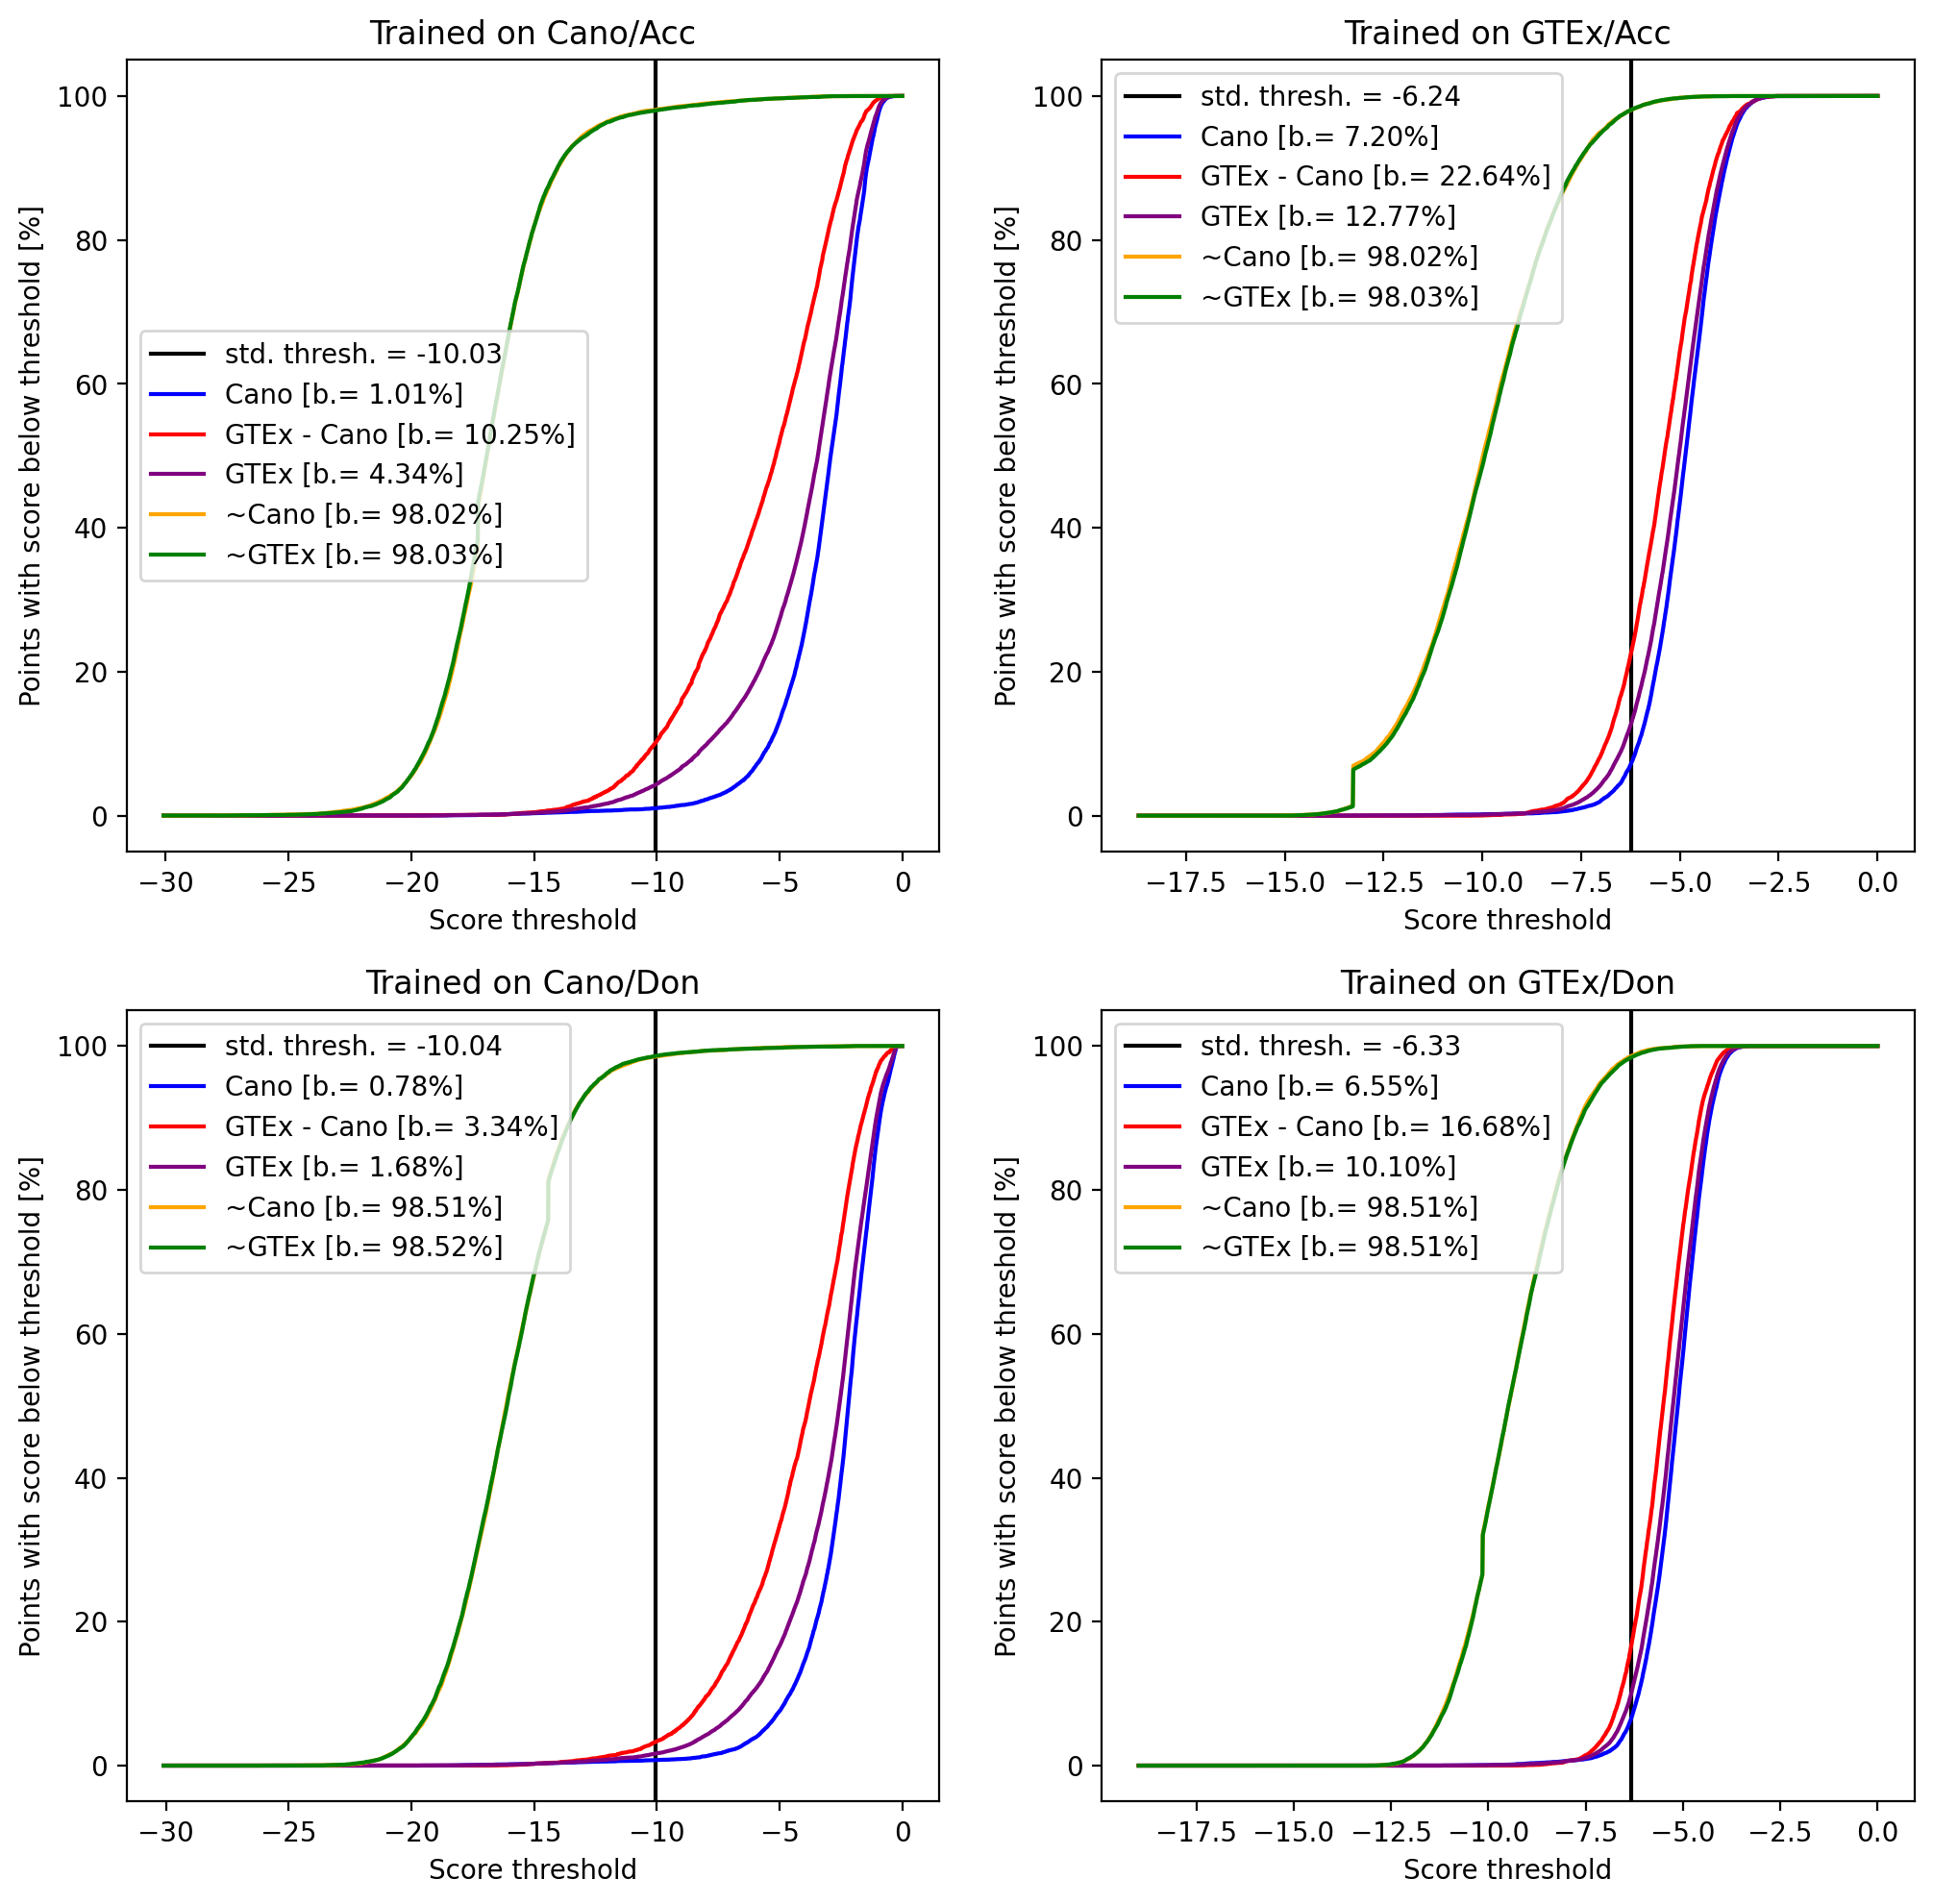

In [12]:
_, axs = plt.subplots(2, 2, figsize=(12, 12), dpi=200)
for c in range(2):
    plot_all(axs[c][0], "Cano", c)
    plot_all(axs[c][1], "GTEx", c)